# Time Series Forecasting with TensorFlow

### Contents of this notebook
  * Get the time series data
    * Load the time series data using Pandas/Python,s CSV module
  * Format data for a time series problem
    * Creating training and test sets (the wrong way)
    * Creating training and test sets (the right way)
    * Visualizing time series data
    * Turning time series data into a supervised learning problem (windowing)
    * Preparing univariate and multivariate
  * Evaluating a time series forecasting model
  * Setting up a series of deep learning modelling experiments
    * Dense (fully-connected) networks
    * Sequence models (LSTM and 1D CNN)
    * Ensembling (combining multiple models together)
    * Multivariate models
    * Replicating the N-BEATS algorithm using TensorFlow layer subclassing
  * Creating a model checkpoint to save the best performing model during training
  * Making predictions (forecasts) with a time series model
  * Creating prediction intervals for the time series model forecasts
  * Discussing two different types of uncertainity in machine learning (data uncertainity and model uncertainity)
  * Demonstrating why forecasting in an open system is BS (the turkey problem)

### Check for GPU

In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-f7f88ee1-d008-e0ad-6e48-12128534f172)


## Get data

In [2]:
# Download Bitcoin historical data from GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2023-03-06 17:51:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.004s  

2023-03-06 17:51:52 (40.8 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas

In [3]:
# Import with pandas
import pandas as pd
import numpy as np
df = pd.read_csv('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv',
                 parse_dates=['Date'],
                 index_col=['Date'])

In [4]:
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [6]:
df.shape

(2787, 5)

In [7]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df['Closing Price (USD)']).rename(columns={'Closing Price (USD)': 'Price'})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


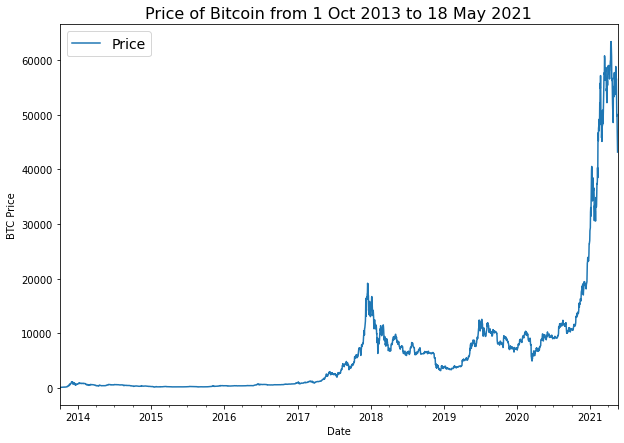

In [8]:
# Visulaizing data
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.legend(fontsize=14)

### Importing time series data with Python's CSV module

In [9]:
# Importing and formatting historical Bitcoin data with Python

import csv
from datetime import datetime

timesteps = []
btc_price = []
with open('/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv') as f:
  csv_reader = csv.reader(f, delimiter=',')
  next(csv_reader)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d"))
    btc_price.append(float(line[2]))

# View first 10 of each

timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

Text(0.5, 0, 'Date')

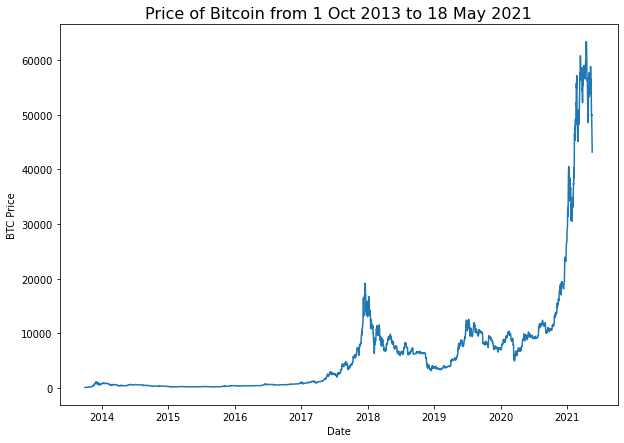

In [10]:
# Plot from CSV
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.ylabel('BTC Price')
plt.title('Price of Bitcoin from 1 Oct 2013 to 18 May 2021', fontsize=16)
plt.xlabel('Date')

## Formatting data for time series problem

### Creating train and test sets for time series data (the wrong way)

In [11]:
# Get Bitcoin date array

timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [12]:
# Wrong way to make train test split

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps,
                                                    prices,
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

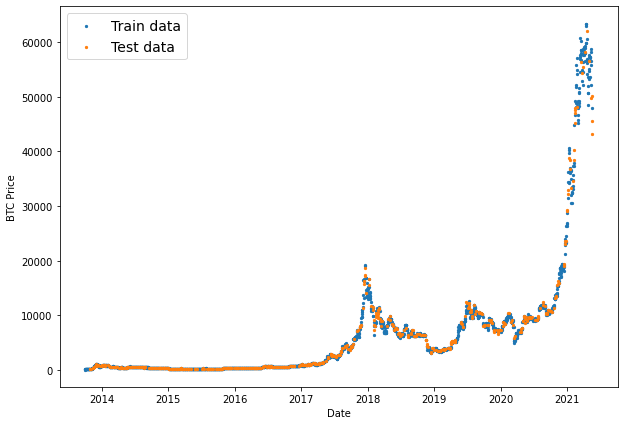

In [13]:
# Plotting wrong train and test splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating train and test sets for time series data (the right way)

In [14]:
split_size = int(0.8 * len(prices))

X_train, y_train = timesteps[0:split_size], prices[:split_size]

X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

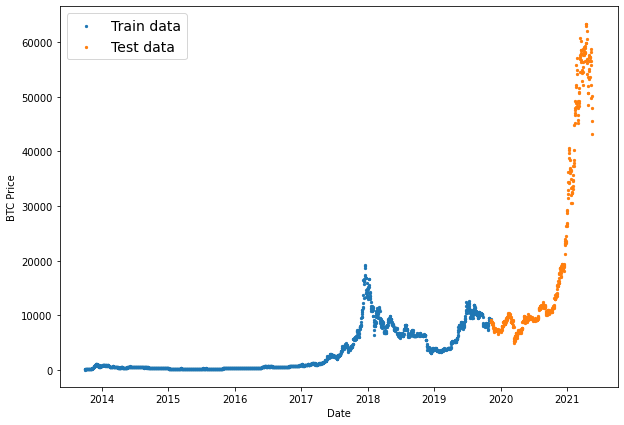

In [15]:
# Plot correctly made splits

plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.legend(fontsize=14)
plt.show()

### Creating a plotting function

In [16]:
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel('Time')
  plt.ylabel('BTC Price')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True) 

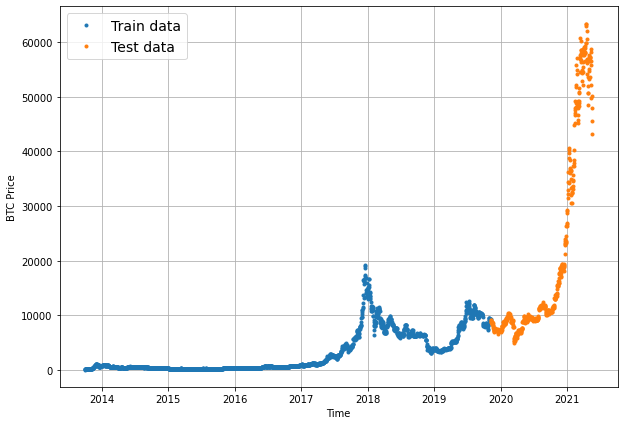

In [17]:
# Try out our plotting function

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')

## Modelling Experiments

### Model 0: Naive Forecast (baseline)

In [18]:
# Create a naive forecast

naive_forecast = y_test[:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

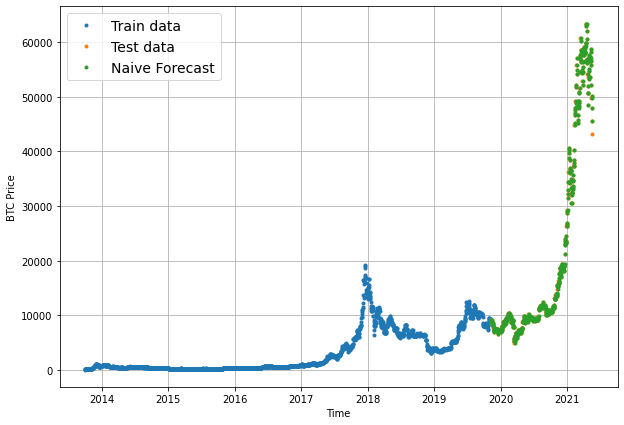

In [19]:
# Plot naive forecast

plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, label='Naive Forecast')

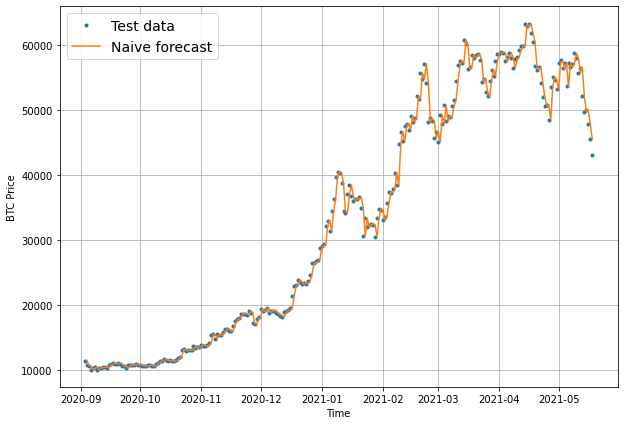

In [20]:
# Zooming in the plot

plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(timesteps=X_test, values=y_test, start=offset, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=offset, format='-', label='Naive forecast')


### Evaluating a time series model

In [21]:
import tensorflow as tf

In [22]:
# Create a function to calculate MASE (mean absolute scaled error)

def mean_absolute_scaled_error(y_true, y_pred):
  
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1]))
  
  return mae/mae_naive_no_season

In [23]:
# Create a function to calculate results (predictions)

def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [24]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

### Other models/libraries for time series forecasting
  * Moving average
  * ARIMA (AutoRegression Integrated Moving Average)
  * Sktime (Scikit-learn for time series)
  * TensorFlow Decision Forecasts (random forest, gradient boosting trees)
  * Facebook Kats (purpose built forecasting and time series analysis library by facebook)
  * LinkedIn Greykite (flexible, intuitive and fast forecasts)


### Windowing dataset

In [25]:
HORIZON = 1           # Predict 1 step at a time
WINDOW_SIZE = 7       # Use a week worth of timestamps to predict the horizon

In [26]:
# Create a function to label windowed data

def get_labelled_windows(x, horizon=1):

  return x[:,:-horizon], x[:,-horizon:]

In [27]:
# Test out the window labelling function

test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1, axis=0), horizon=HORIZON)
print(f"Window: {test_window} -> Label: {test_label}")

Window: [[1 2 3 4 5 6 7]] -> Label: [[8]]


In [28]:
# Create a function to view NumPy arrays as windows

def make_windows(x, window_size=7, horizon=1):

  # 1. Create a window of specific window size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for zero indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon-1)), axis=0).T

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)

  return windows, labels

In [29]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [30]:
# View the first three windows/labels

for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


### Turning windows into training and test sets

In [31]:
# Make the train test split

def make_train_test_split(windows, labels, test_split=0.2):

  split_size = int(len(windows) * (1-test_split))
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels

In [32]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [33]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

### Make modelling checkpoint

In [34]:
import os

# Create a function ti implement model checkpoint callback with a specific filename

def create_model_checkpoint(model_name, save_path="model_experiments"):
  
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0,
                                            save_best_only=True)

### Model 1: Dense model (window = 7, horizon = 1)

In [35]:
import tensorflow as tf
from tensorflow.keras import layers

# Set seed
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

Epoch 1/100
16/18 [=========================>....] - ETA: 0s - loss: 1526.6259 - mae: 1526.6259

18/18 [==============================] - 9s 143ms/step - loss: 1420.7891 - mae: 1420.7891 - val_loss: 2062.3831 - val_mae: 2062.3831
Epoch 2/100
14/18 [======================>.......] - ETA: 0s - loss: 346.3853 - mae: 346.3853

18/18 [==============================] - 2s 126ms/step - loss: 324.4267 - mae: 324.4267 - val_loss: 1474.9070 - val_mae: 1474.9070
Epoch 3/100
 1/18 [>.............................] - ETA: 0s - loss: 208.0542 - mae: 208.0542

18/18 [==============================] - 1s 52ms/step - loss: 175.3946 - mae: 175.3946 - val_loss: 1125.5236 - val_mae: 1125.5236
Epoch 4/100
13/18 [====================>.........] - ETA: 0s - loss: 162.8923 - mae: 162.8923

18/18 [==============================] - 1s 63ms/step - loss: 155.3437 - mae: 155.3437 - val_loss: 845.5929 - val_mae: 845.5929
Epoch 5/100
10/18 [===============>..............] - ETA: 0s - loss: 147.7486 - mae: 147.7486

18/18 [==============================] - 1s 70ms/step - loss: 144.1223 - mae: 144.1223 - val_loss: 804.3881 - val_mae: 804.3881
Epoch 6/100
12/18 [===================>..........] - ETA: 0s - loss: 142.1543 - mae: 142.1543

18/18 [==============================] - 1s 64ms/step - loss: 145.2373 - mae: 145.2373 - val_loss: 787.7986 - val_mae: 787.7986
Epoch 7/100
 1/18 [>.............................] - ETA: 0s - loss: 165.3376 - mae: 165.3376

18/18 [==============================] - 1s 34ms/step - loss: 140.8963 - mae: 140.8963 - val_loss: 776.1492 - val_mae: 776.1492
Epoch 8/100
 1/18 [>.............................] - ETA: 0s - loss: 108.2052 - mae: 108.2052

18/18 [==============================] - 1s 34ms/step - loss: 138.9691 - mae: 138.9691 - val_loss: 765.9215 - val_mae: 765.9215
Epoch 9/100
18/18 [==============================] - 0s 5ms/step - loss: 140.0345 - mae: 140.0345 - val_loss: 819.7102 - val_mae: 819.7102
Epoch 10/100
 1/18 [>.............................] - ETA: 0s - loss: 148.8771 - mae: 148.8771

18/18 [==============================] - 1s 35ms/step - loss: 138.3614 - mae: 138.3614 - val_loss: 758.4904 - val_mae: 758.4904
Epoch 11/100
 1/18 [>.............................] - ETA: 0s - loss: 139.0618 - mae: 139.0618

18/18 [==============================] - 1s 33ms/step - loss: 133.6162 - mae: 133.6162 - val_loss: 735.8259 - val_mae: 735.8259
Epoch 12/100
18/18 [==============================] - 0s 5ms/step - loss: 131.3016 - mae: 131.3016 - val_loss: 781.4398 - val_mae: 781.4398
Epoch 13/100
18/18 [==============================] - 0s 7ms/step - loss: 132.4879 - mae: 132.4879 - val_loss: 736.3998 - val_mae: 736.3998
Epoch 14/100
11/18 [=================>............] - ETA: 0s - loss: 122.4709 - mae: 122.4709

18/18 [==============================] - 1s 49ms/step - loss: 127.6481 - mae: 127.6481 - val_loss: 704.5410 - val_mae: 704.5410
Epoch 15/100
12/18 [===================>..........] - ETA: 0s - loss: 122.0366 - mae: 122.0366

18/18 [==============================] - 1s 46ms/step - loss: 128.2651 - mae: 128.2651 - val_loss: 698.3264 - val_mae: 698.3264
Epoch 16/100
18/18 [==============================] - 0s 5ms/step - loss: 125.7338 - mae: 125.7338 - val_loss: 721.6892 - val_mae: 721.6892
Epoch 17/100
16/18 [=========================>....] - ETA: 0s - loss: 122.0224 - mae: 122.0224

18/18 [==============================] - 1s 64ms/step - loss: 124.9466 - mae: 124.9466 - val_loss: 684.0041 - val_mae: 684.0041
Epoch 18/100
15/18 [========================>.....] - ETA: 0s - loss: 128.1400 - mae: 128.1400

18/18 [==============================] - 1s 70ms/step - loss: 123.8006 - mae: 123.8006 - val_loss: 670.3452 - val_mae: 670.3452
Epoch 19/100
18/18 [==============================] - 0s 15ms/step - loss: 123.6747 - mae: 123.6747 - val_loss: 674.3986 - val_mae: 674.3986
Epoch 20/100
17/18 [===========================>..] - ETA: 0s - loss: 125.2518 - mae: 125.2518

18/18 [==============================] - 1s 53ms/step - loss: 125.3772 - mae: 125.3772 - val_loss: 662.5864 - val_mae: 662.5864
Epoch 21/100
18/18 [==============================] - 0s 7ms/step - loss: 126.1110 - mae: 126.1110 - val_loss: 676.3805 - val_mae: 676.3805
Epoch 22/100
18/18 [==============================] - 0s 8ms/step - loss: 121.5063 - mae: 121.5063 - val_loss: 673.2426 - val_mae: 673.2426
Epoch 23/100
 1/18 [>.............................] - ETA: 0s - loss: 121.4225 - mae: 121.4225

18/18 [==============================] - 1s 42ms/step - loss: 121.8620 - mae: 121.8620 - val_loss: 654.1276 - val_mae: 654.1276
Epoch 24/100
12/18 [===================>..........] - ETA: 0s - loss: 122.2146 - mae: 122.2146

18/18 [==============================] - 1s 48ms/step - loss: 120.3795 - mae: 120.3795 - val_loss: 645.6735 - val_mae: 645.6735
Epoch 25/100
13/18 [====================>.........] - ETA: 0s - loss: 124.4546 - mae: 124.4546

18/18 [==============================] - 1s 51ms/step - loss: 119.8364 - mae: 119.8364 - val_loss: 643.7601 - val_mae: 643.7601
Epoch 26/100
14/18 [======================>.......] - ETA: 0s - loss: 120.7912 - mae: 120.7912

18/18 [==============================] - 1s 57ms/step - loss: 120.0860 - mae: 120.0860 - val_loss: 639.8945 - val_mae: 639.8945
Epoch 27/100
 1/18 [>.............................] - ETA: 0s - loss: 161.8213 - mae: 161.8213

18/18 [==============================] - 1s 43ms/step - loss: 120.3137 - mae: 120.3137 - val_loss: 634.9780 - val_mae: 634.9780
Epoch 28/100
18/18 [==============================] - 0s 7ms/step - loss: 119.6230 - mae: 119.6230 - val_loss: 676.1167 - val_mae: 676.1167
Epoch 29/100
18/18 [==============================] - 0s 9ms/step - loss: 124.2573 - mae: 124.2573 - val_loss: 672.2053 - val_mae: 672.2053
Epoch 30/100
18/18 [==============================] - 0s 8ms/step - loss: 122.0286 - mae: 122.0286 - val_loss: 673.2625 - val_mae: 673.2625
Epoch 31/100
18/18 [==============================] - 0s 8ms/step - loss: 123.6989 - mae: 123.6989 - val_loss: 819.9166 - val_mae: 819.9166
Epoch 32/100
18/18 [==============================] - 0s 9ms/step - loss: 124.4257 - mae: 124.4257 - val_loss: 682.6122 - val_mae: 682.6122
Epoch 33/100
18/18 [==============================] - 0s 7ms/step - loss: 119.0693 - mae: 119.0693 - val_loss: 647.4818 - val_mae: 647.4818
Epoch 34/100
10/18 [============

18/18 [==============================] - 1s 71ms/step - loss: 117.8471 - mae: 117.8471 - val_loss: 622.7822 - val_mae: 622.7822
Epoch 35/100
 1/18 [>.............................] - ETA: 0s - loss: 99.9616 - mae: 99.9616

18/18 [==============================] - 1s 44ms/step - loss: 116.4878 - mae: 116.4878 - val_loss: 616.9371 - val_mae: 616.9371
Epoch 36/100
18/18 [==============================] - 0s 8ms/step - loss: 125.8493 - mae: 125.8493 - val_loss: 774.8558 - val_mae: 774.8558
Epoch 37/100
18/18 [==============================] - 0s 8ms/step - loss: 119.2922 - mae: 119.2922 - val_loss: 617.0648 - val_mae: 617.0648
Epoch 38/100
11/18 [=================>............] - ETA: 0s - loss: 119.7856 - mae: 119.7856

18/18 [==============================] - 1s 53ms/step - loss: 115.1567 - mae: 115.1567 - val_loss: 610.1678 - val_mae: 610.1678
Epoch 39/100
18/18 [==============================] - 0s 8ms/step - loss: 115.5889 - mae: 115.5889 - val_loss: 647.8517 - val_mae: 647.8517
Epoch 40/100
11/18 [=================>............] - ETA: 0s - loss: 112.5895 - mae: 112.5895

18/18 [==============================] - 1s 54ms/step - loss: 114.4247 - mae: 114.4247 - val_loss: 606.1285 - val_mae: 606.1285
Epoch 41/100
18/18 [==============================] - 0s 14ms/step - loss: 113.7084 - mae: 113.7084 - val_loss: 609.3045 - val_mae: 609.3045
Epoch 42/100
11/18 [=================>............] - ETA: 0s - loss: 118.3286 - mae: 118.3286

18/18 [==============================] - 2s 126ms/step - loss: 117.1591 - mae: 117.1591 - val_loss: 603.4376 - val_mae: 603.4376
Epoch 43/100
18/18 [==============================] - 0s 8ms/step - loss: 112.5438 - mae: 112.5438 - val_loss: 614.6165 - val_mae: 614.6165
Epoch 44/100
18/18 [==============================] - 0s 11ms/step - loss: 113.5177 - mae: 113.5177 - val_loss: 622.5833 - val_mae: 622.5833
Epoch 45/100
18/18 [==============================] - 0s 8ms/step - loss: 112.9186 - mae: 112.9186 - val_loss: 613.6995 - val_mae: 613.6995
Epoch 46/100
12/18 [===================>..........] - ETA: 0s - loss: 118.3119 - mae: 118.3119

18/18 [==============================] - 1s 60ms/step - loss: 114.0998 - mae: 114.0998 - val_loss: 599.0925 - val_mae: 599.0925
Epoch 47/100
18/18 [==============================] - 0s 7ms/step - loss: 112.1698 - mae: 112.1698 - val_loss: 640.3425 - val_mae: 640.3425
Epoch 48/100
18/18 [==============================] - 0s 5ms/step - loss: 112.5430 - mae: 112.5430 - val_loss: 654.5294 - val_mae: 654.5294
Epoch 49/100
 1/18 [>.............................] - ETA: 0s - loss: 169.8484 - mae: 169.8484

18/18 [==============================] - 1s 35ms/step - loss: 120.1928 - mae: 120.1928 - val_loss: 599.0049 - val_mae: 599.0049
Epoch 50/100
18/18 [==============================] - 0s 5ms/step - loss: 110.7829 - mae: 110.7829 - val_loss: 653.9103 - val_mae: 653.9103
Epoch 51/100
18/18 [==============================] - 0s 7ms/step - loss: 113.0332 - mae: 113.0332 - val_loss: 632.5305 - val_mae: 632.5305
Epoch 52/100
18/18 [==============================] - 0s 11ms/step - loss: 113.6211 - mae: 113.6211 - val_loss: 614.1528 - val_mae: 614.1528
Epoch 53/100
10/18 [===============>..............] - ETA: 0s - loss: 111.2900 - mae: 111.2900

18/18 [==============================] - 1s 54ms/step - loss: 116.7080 - mae: 116.7080 - val_loss: 592.2003 - val_mae: 592.2003
Epoch 54/100
18/18 [==============================] - 0s 10ms/step - loss: 113.5299 - mae: 113.5299 - val_loss: 667.0688 - val_mae: 667.0688
Epoch 55/100
18/18 [==============================] - 0s 10ms/step - loss: 115.0583 - mae: 115.0583 - val_loss: 617.3811 - val_mae: 617.3811
Epoch 56/100
18/18 [==============================] - 0s 5ms/step - loss: 117.8449 - mae: 117.8449 - val_loss: 881.4427 - val_mae: 881.4427
Epoch 57/100
18/18 [==============================] - 0s 5ms/step - loss: 138.2719 - mae: 138.2719 - val_loss: 634.7535 - val_mae: 634.7535
Epoch 58/100
18/18 [==============================] - 0s 7ms/step - loss: 116.9634 - mae: 116.9634 - val_loss: 643.7042 - val_mae: 643.7042
Epoch 59/100
18/18 [==============================] - 0s 8ms/step - loss: 111.4456 - mae: 111.4456 - val_loss: 615.7376 - val_mae: 615.7376
Epoch 60/100
18/18 [==========

18/18 [==============================] - 1s 52ms/step - loss: 113.7288 - mae: 113.7288 - val_loss: 590.0942 - val_mae: 590.0942
Epoch 66/100
18/18 [==============================] - 0s 7ms/step - loss: 114.0765 - mae: 114.0765 - val_loss: 618.0225 - val_mae: 618.0225
Epoch 67/100
18/18 [==============================] - 0s 8ms/step - loss: 108.9937 - mae: 108.9937 - val_loss: 632.7889 - val_mae: 632.7889
Epoch 68/100
18/18 [==============================] - 0s 8ms/step - loss: 113.2219 - mae: 113.2219 - val_loss: 635.4833 - val_mae: 635.4833
Epoch 69/100
18/18 [==============================] - 0s 6ms/step - loss: 123.1641 - mae: 123.1641 - val_loss: 640.5092 - val_mae: 640.5092
Epoch 70/100
18/18 [==============================] - 0s 5ms/step - loss: 123.2978 - mae: 123.2978 - val_loss: 621.6151 - val_mae: 621.6151
Epoch 71/100
18/18 [==============================] - 0s 9ms/step - loss: 110.5895 - mae: 110.5895 - val_loss: 605.2823 - val_mae: 605.2823
Epoch 72/100
13/18 [============

18/18 [==============================] - 1s 50ms/step - loss: 109.3424 - mae: 109.3424 - val_loss: 578.6955 - val_mae: 578.6955
Epoch 73/100
18/18 [==============================] - 0s 7ms/step - loss: 111.8412 - mae: 111.8412 - val_loss: 619.6148 - val_mae: 619.6148
Epoch 74/100
18/18 [==============================] - 0s 8ms/step - loss: 107.7834 - mae: 107.7834 - val_loss: 585.5598 - val_mae: 585.5598
Epoch 75/100
18/18 [==============================] - 0s 8ms/step - loss: 109.4420 - mae: 109.4420 - val_loss: 632.2579 - val_mae: 632.2579
Epoch 76/100
18/18 [==============================] - 0s 7ms/step - loss: 114.9797 - mae: 114.9797 - val_loss: 586.8243 - val_mae: 586.8243
Epoch 77/100
13/18 [====================>.........] - ETA: 0s - loss: 115.4009 - mae: 115.4009

18/18 [==============================] - 1s 58ms/step - loss: 111.9919 - mae: 111.9919 - val_loss: 575.4524 - val_mae: 575.4524
Epoch 78/100
18/18 [==============================] - 0s 5ms/step - loss: 107.4481 - mae: 107.4481 - val_loss: 577.0170 - val_mae: 577.0170
Epoch 79/100
18/18 [==============================] - 0s 5ms/step - loss: 107.9696 - mae: 107.9696 - val_loss: 588.7568 - val_mae: 588.7568
Epoch 80/100
18/18 [==============================] - 0s 10ms/step - loss: 107.8684 - mae: 107.8684 - val_loss: 576.1404 - val_mae: 576.1404
Epoch 81/100
15/18 [========================>.....] - ETA: 0s - loss: 107.9482 - mae: 107.9482

18/18 [==============================] - 2s 133ms/step - loss: 107.0842 - mae: 107.0842 - val_loss: 573.4978 - val_mae: 573.4978
Epoch 82/100
18/18 [==============================] - 0s 8ms/step - loss: 115.5826 - mae: 115.5826 - val_loss: 575.1632 - val_mae: 575.1632
Epoch 83/100
18/18 [==============================] - 0s 10ms/step - loss: 111.6083 - mae: 111.6083 - val_loss: 661.8805 - val_mae: 661.8805
Epoch 84/100
18/18 [==============================] - 0s 8ms/step - loss: 111.9316 - mae: 111.9316 - val_loss: 581.4023 - val_mae: 581.4023
Epoch 85/100
18/18 [==============================] - 0s 8ms/step - loss: 108.0286 - mae: 108.0286 - val_loss: 598.5648 - val_mae: 598.5648
Epoch 86/100
18/18 [==============================] - 0s 8ms/step - loss: 112.0907 - mae: 112.0907 - val_loss: 643.9697 - val_mae: 643.9697
Epoch 87/100
18/18 [==============================] - 0s 10ms/step - loss: 107.7936 - mae: 107.7936 - val_loss: 591.8896 - val_mae: 591.8896
Epoch 88/100
18/18 [=========

18/18 [==============================] - 1s 39ms/step - loss: 109.1267 - mae: 109.1267 - val_loss: 571.2167 - val_mae: 571.2167
Epoch 93/100
18/18 [==============================] - 0s 11ms/step - loss: 113.5573 - mae: 113.5573 - val_loss: 628.9199 - val_mae: 628.9199
Epoch 94/100
18/18 [==============================] - 0s 8ms/step - loss: 111.0034 - mae: 111.0034 - val_loss: 603.5600 - val_mae: 603.5600
Epoch 95/100
18/18 [==============================] - 0s 8ms/step - loss: 108.4877 - mae: 108.4877 - val_loss: 573.5374 - val_mae: 573.5374
Epoch 96/100
18/18 [==============================] - 0s 8ms/step - loss: 114.9330 - mae: 114.9330 - val_loss: 612.5002 - val_mae: 612.5002
Epoch 97/100
18/18 [==============================] - 0s 7ms/step - loss: 108.9325 - mae: 108.9325 - val_loss: 590.1594 - val_mae: 590.1594
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 109.4936 - mae: 109.4936 - val_loss: 579.5129 - val_mae: 579.5129
Epoch 99/100
15/18 [===========

18/18 [==============================] - 1s 49ms/step - loss: 108.9363 - mae: 108.9363 - val_loss: 569.6948 - val_mae: 569.6948
Epoch 100/100
18/18 [==============================] - 0s 10ms/step - loss: 106.5366 - mae: 106.5366 - val_loss: 571.8646 - val_mae: 571.8646


In [36]:
# Evaluate model on test data

model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 571.8646 - mae: 571.8646


[571.8646240234375, 571.8646240234375]

In [37]:
# Load in saved best performing model_1 and evaluate on test data

model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 569.6946 - mae: 569.6946


[569.6946411132812, 569.6946411132812]

### Making forecast with model (on the test dataset)

In [38]:
def make_preds(model, input_data):

  forecast = model.predict(input_data)

  return tf.squeeze(forecast)

In [39]:
# Make prediction using model_1 on the test dataset and view the results

model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 3ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8877.993, 8776.653, 9002.241, 8799.125, 8763.747, 8716.688,
        8707.545, 8513.087, 8471.977, 8518.811], dtype=float32)>)

In [40]:
# Evaluate preds

model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_1_preds)
model_1_results

{'mae': 569.6947,
 'mse': 1170304.2,
 'rmse': 1081.806,
 'mape': 2.5785449,
 'mase': 1.0007958}

In [41]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

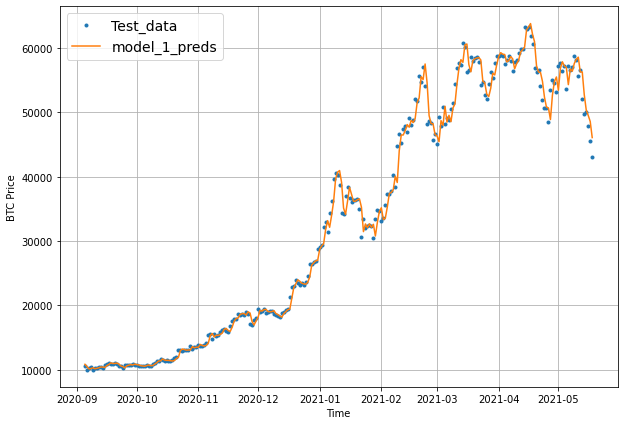

In [42]:
# Visualizing the result

offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:,0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

### Model 2: Dense (window = 30, horizon = 1)

In [43]:
HORIZON = 1
WINDOW_SIZE = 30

In [44]:
# Make windowed data with appropriate horizon nad window size

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [45]:
# Make train and test windows

train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows,
                                                                               labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [46]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

# Compile model
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [47]:
# Evaluate model_2 preds

model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 614.7431


614.7431030273438

In [48]:
# Load in best performing model

model_2 = tf.keras.models.load_model("model_experiments/model_2_dense")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 614.7431


614.7431030273438

In [49]:
# Get forecast predictions

model_2_preds = make_preds(model_2,
                           input_data=test_windows)
model_2_preds[-10:]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([56961.043, 58874.766, 58731.996, 55553.258, 56836.125, 53744.92 ,
       50243.617, 50297.21 , 48814.24 , 46102.316], dtype=float32)>

In [50]:
# Evaluate results for model_2 prediction

model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)

In [51]:
model_2_results

{'mae': 614.7431,
 'mse': 1334673.4,
 'rmse': 1155.2806,
 'mape': 2.7487903,
 'mase': 1.074577}

### Model 3: Dense (window = 30, horizon = 7)

In [52]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [53]:
train_windows, test_windows, train_labels, test_labels = make_train_test_split(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [54]:
tf.random.set_seed(42)

model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name = "model_3_dense")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [55]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1329.9672


1329.9671630859375

In [56]:
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1220.3524


1220.3524169921875

In [57]:
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[-5:]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[55236.08 , 55621.246, 56346.   , 56492.785, 56190.41 , 56773.67 ,
        56282.258],
       [56723.355, 57432.77 , 57852.387, 58578.824, 58041.73 , 58182.1  ,
        57648.336],
       [58946.754, 58496.727, 59701.21 , 58681.613, 60076.336, 59491.117,
        60817.805],
       [58013.04 , 57991.703, 58966.742, 59886.66 , 60192.445, 60246.98 ,
        59472.184],
       [55788.688, 57178.18 , 58192.867, 58535.004, 57951.16 , 57453.484,
        58851.332]], dtype=float32)>

In [58]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  723.30273 ,   465.28726 ,   438.6695  ,   544.51715 ,
          473.37918 ,   545.0514  ,   540.53754 ,   579.9775  ,
          544.55743 ,   645.625   ,   831.7848  ,   836.5353  ,
          846.9815  ,   838.89734 ,   621.14905 ,   275.3022  ,
          166.56912 ,   213.89334 ,   209.58301 ,   272.04623 ,
          153.05037 ,   190.52832 ,   326.6275  ,   253.35156 ,
          180.6926  ,    86.231514,    89.29792 ,   140.0009  ,
          175.4133  ,   229.39188 ,   345.91873 ,   426.0602  ,
          390.11664 ,   365.62375 ,   348.0529  ,   329.58572 ,
          362.2717  ,   258.05588 ,   222.81961 ,   213.01492 ,
          405.5687  ,    66.546875,   113.88993 ,   118.74456 ,
          106.88058 ,    96.140976,    93.38163 ,   102.7862  ,
          134.41504 ,   157.73416 ,   164.83455 ,   176.43547 ,
          219.74846 ,   217.06808 ,   183.3773  ,   302.3527  ,
          504.01324 ,   433.45416 ,   468.90793 ,   442.19357 ,
          295.03125 ,   188.94637

### Make our evaluation function work for larger horizon

In [59]:
def evaluate_preds(y_true, y_pred):

  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)
  
  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [60]:
# Get model_3 reults

model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1220.3523,
 'mse': 5388074.5,
 'rmse': 1401.6492,
 'mape': 5.4840965,
 'mase': 2.1715488}

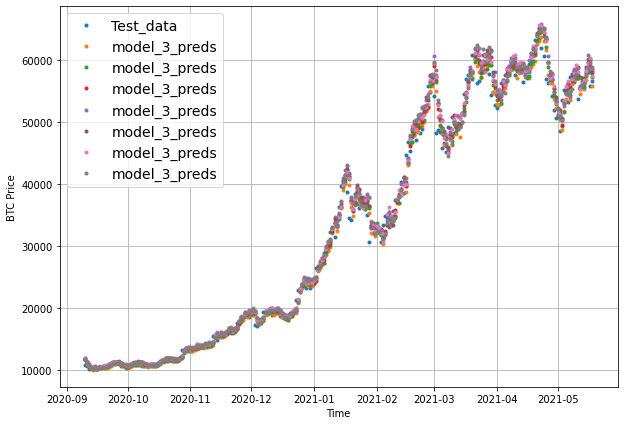

In [61]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")

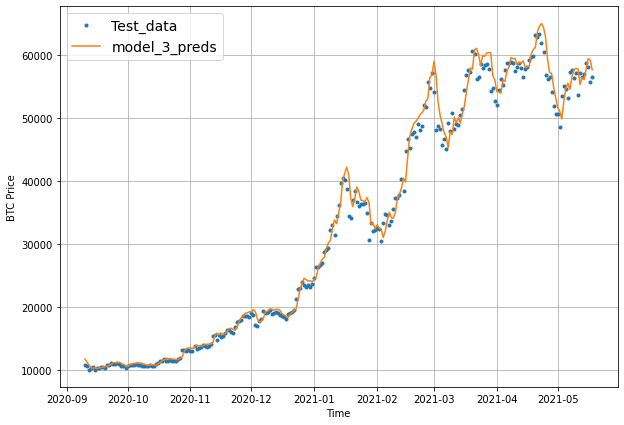

In [62]:
offset = 300
plt.figure(figsize=(10, 7))

plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), format="-", start=offset, label="model_3_preds")

### Which of our model is performing best so far?

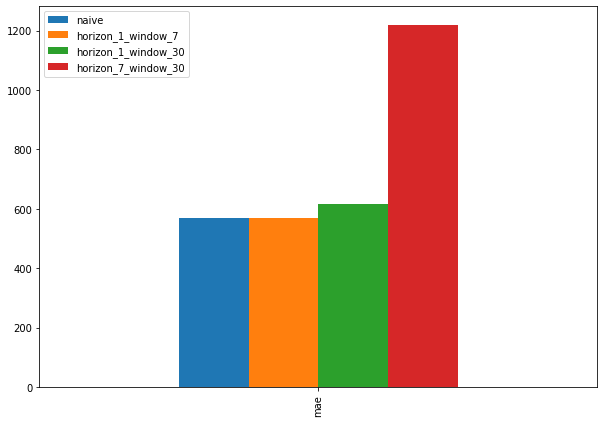

In [63]:
pd.DataFrame({"naive":naive_results["mae"],
              "horizon_1_window_7":model_1_results["mae"],
              "horizon_1_window_30":model_2_results["mae"],
              "horizon_7_window_30":model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");

### Model 4: Conv1D

In [64]:
HORIZON = 1
WINDOW_SIZE = 7

In [65]:
# Create windowed dataset

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [66]:
# Create test/train splits

train_windows, test_windows, train_labels, test_labels = make_train_test_split(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [67]:
# Check data sample shapes
train_windows[0].shape

(7,)

In [68]:
# Before we pass our data to conv1D, we have to reshape it to make sure it works

x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))
print(f"Original shape: {x.shape}")
print(f"Expanded shape: {expand_dims_layer(x).shape}")
print(f"Original values with Expanded shape:\n{expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with Expanded shape:
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [69]:
tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
    layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
    layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
    layers.Dense(HORIZON)
], name="model_4_Conv1D")

model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_4.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [70]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [71]:
model_4 = tf.keras.models.load_model("model_experiments/model_4_Conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 5ms/step - loss: 571.2362


571.2362060546875

In [72]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:5]

18/18 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8875.188, 8758.479, 8972.306, 8789.844, 8732.454], dtype=float32)>

In [73]:
# Evaluate predictions

model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 571.2362,
 'mse': 1189575.5,
 'rmse': 1090.6766,
 'mape': 2.572712,
 'mase': 1.0035038}

### Model 5: RNN (LSTM)

In [74]:
tf.random.set_seed(42)

# Let's an LSTM model with the functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# print(x.shape)
# x= layers.LSTM(128, activation="relu", return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# print(x.shape)
# Add another optional dense layer
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile the model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
18/18 [==============================] - 9s 363ms/step - loss: 2418.9199 - val_loss: 10579.7783
Epoch 2/100
18/18 [==============================] - 4s 234ms/step - loss: 962.6599 - val_loss: 1197.5081
Epoch 3/100
18/18 [==============================] - 3s 199ms/step - loss: 273.8763 - val_loss: 1143.1415
Epoch 4/100
18/18 [==============================] - 5s 269ms/step - loss: 216.0846 - val_loss: 1105.1442
Epoch 5/100
18/18 [==============================] - 0s 8ms/step - loss: 202.5763 - val_loss: 1118.5900
Epoch 6/100
18/18 [==============================] - 4s 215ms/step - loss: 197.4505 - val_loss: 1082.7407
Epoch 7/100
18/18 [==============================] - 0s 15ms/step - loss: 193.3559 - val_loss: 1094.6616
Epoch 8/100
18/18 [==============================] - 0s 13ms/step - loss: 190.1240 - val_loss: 1091.0166
Epoch 9/100
18/18 [==============================] - 3s 173ms/step - loss: 187.5850 - val_loss: 1074.7979
Epoch 10/100
18/18 [============================

In [75]:
# Load in the best version of model 5 and evaluate

model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 585.4004


585.400390625

In [76]:
# Make prediction with our LSTM model

model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8926.457, 8792.772, 8962.612, 8770.388, 8750.71 , 8752.163,
       8676.86 , 8525.925, 8479.472, 8500.566], dtype=float32)>

In [77]:
# Evaluate model 5 preds

model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 585.4004,
 'mse': 1221859.2,
 'rmse': 1105.3774,
 'mape': 2.6357903,
 'mase': 1.0283864}

### Make a multivariate time series

In [78]:
# Lets make a multivariate time series

bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [79]:
# Block reward values

block_reward_1 = 50
block_reward_2 = 25
block_reward_3 = 12.5
block_reward_4 = 6.25

# Block reward dates

block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [80]:
# Get datetime indexes for when to add in different block dates

block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [81]:
# Add block reward column

bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Set values of block reward column

bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days: block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


<AxesSubplot:xlabel='Date'>

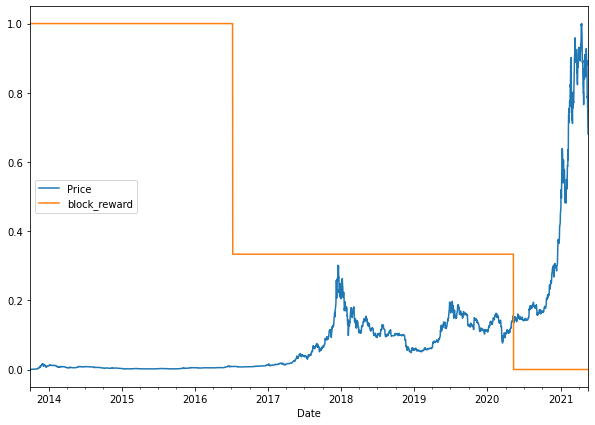

In [82]:
# Plot the block reward/price over time

from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7))

### Making a windowed dataset with pandas

In [83]:
# Setup dataset hyperparameters

HORIZON = 1
WINDOW_SIZE = 7

In [84]:
# Make a copy of the bitcoin historical data with block reward feature

bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns

for i in range(WINDOW_SIZE):
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [85]:
# Lets create X & y, remove the Nans and convert to float32 to prevent TensorFlow errors

X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [86]:
# View labels

y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [87]:
# Make train and tests

split_size = int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

### Model 6: Dense (multivariate time series)

In [88]:
# Make multivariate time series model

tf.random.set_seed(42)
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    # Layers.Dense(128, activation="relu"), # Adding an extra layer here should lead to beating the native model
    layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [89]:
# Make sure best model is loaded and evaluate

model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 7ms/step - loss: 568.3263


568.3262939453125

In [90]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

18/18 [==============================] - 0s 5ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8900.908, 8792.144, 9042.507, 8835.526, 8755.434, 8750.286,
       8729.736, 8533.919, 8488.756, 8546.374], dtype=float32)>

In [91]:
# Evaluate preds

model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 568.32635,
 'mse': 1174747.0,
 'rmse': 1083.8574,
 'mape': 2.5434413,
 'mase': 0.998392}

In [92]:
model_1_results

{'mae': 569.6947,
 'mse': 1170304.2,
 'rmse': 1081.806,
 'mape': 2.5785449,
 'mase': 1.0007958}

### Model 7: N-BEATS algorithm

In [93]:
# Create NBeatsBlock custom layer

class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs takes crae of all the parameters for the parent class
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Output of block is theta layerwith linear activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon]

    return backcast, forecast

In [94]:
# Setup dummy NBeatsBlock layer to represent inouts and outputs

dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [95]:
# Create dummy inputs (have to be same size as input size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis=0)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [96]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.02276666 -0.5720686  -0.00360629  0.0017596  -0.6110145  -0.29431096
  0.09778398]
Forecast: 0.3393453359603882


### Preparing data for N-BEATS algorithm using tf.data

In [97]:
HORIZON = 1 # how far to predict
WINDOW_SIZE = 7 # how far to lookback

In [98]:
# Create NBEATS data inputs
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [99]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Prices+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Prices+1,Prices+2,Prices+3,Prices+4,Prices+5,Prices+6,Prices+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [100]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()['Price']

# Make train and test sets
split_size = int(len(X)*0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

In [101]:
# 1. Turn train and test sets into tensor datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features and labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

In [102]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D

N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connections

In [103]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, Compiling and Fitting the N-BEATS algorithm

In [104]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link
residuals = layers.subtract([stack_input, backcast], name="subtract_00")

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)):

  # 5. Use the NBeatsBlock to calculate the backcast and forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Compile the model
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                       tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 185: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 351: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 451: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
CPU times: user 2min 35s, sys: 3.13 s, total: 2min 38s
Wall time: 3min 15s


In [105]:
# Evaluate N-BEATS model on test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 23ms/step - loss: 587.1863 - mae: 587.1863 - mse: 1176713.0000


[587.1863403320312, 587.1863403320312, 1176713.0]

In [106]:
# Make predictions with N-Beats model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]

1/1 [==============================] - 1s 1s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8860.504, 8795.82 , 9053.81 , 8732.739, 8804.252, 8819.228,
       8618.47 , 8521.009, 8516.866, 8511.205], dtype=float32)>

In [107]:
# Evaluate N-BEATS model prediction
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 587.18634,
 'mse': 1176713.0,
 'rmse': 1084.764,
 'mape': 2.7546864,
 'mase': 1.0315238}

### Plotting N-BEATS architecture we have created

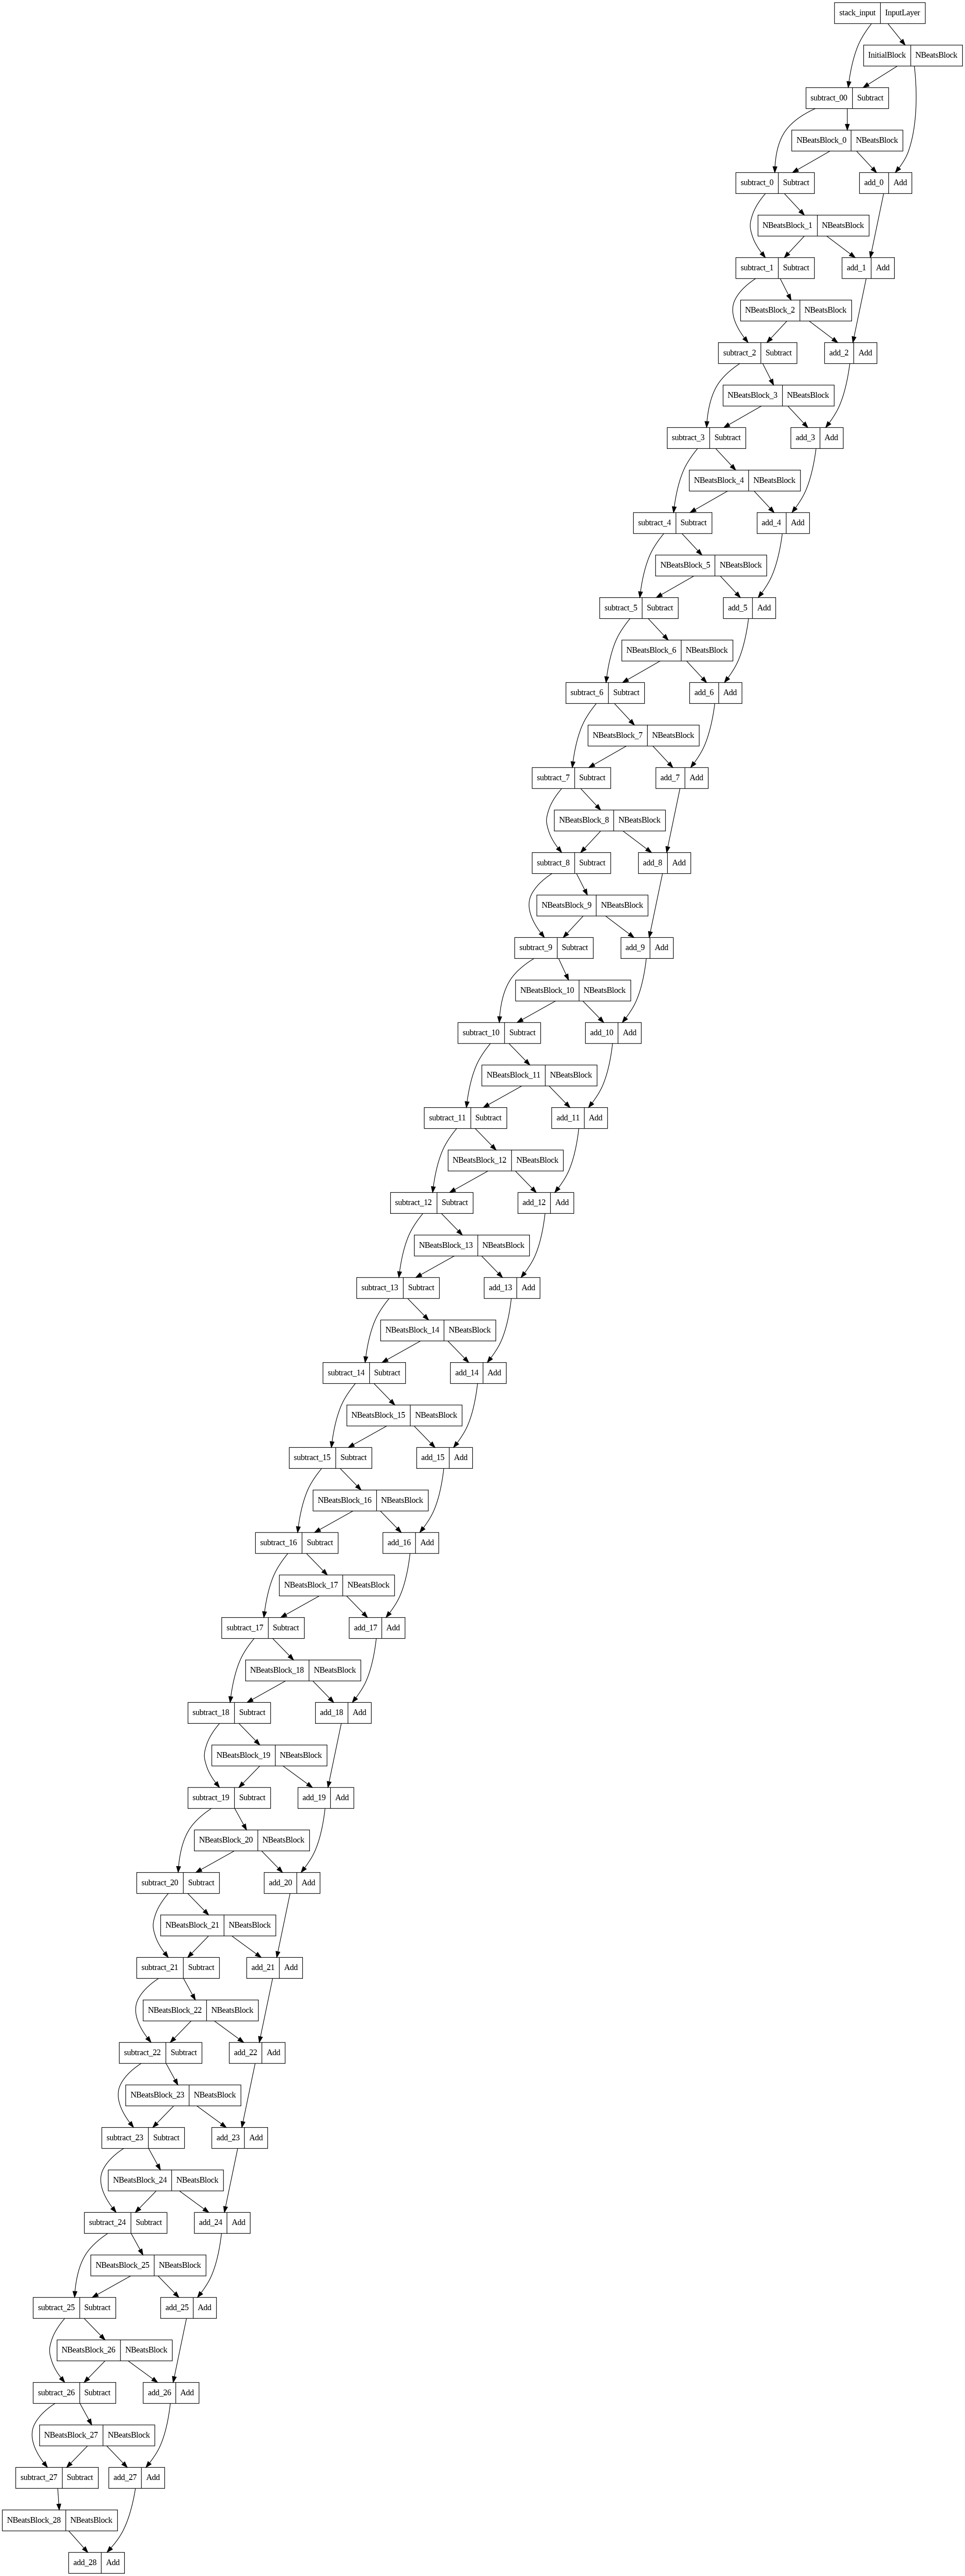

In [108]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

In [109]:
model_7.save(model_7.name)

### Model 8: Creating an ensemble (stacking different models together)

In [110]:
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=['mae', 'mse', 'mape']):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  For eg. if num_iter=10, Total number of models returned=30
  """

  # Make empty list for trained ensemble models
  ensemble_models = []

  # Create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with a different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # Construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
          layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['mae', 'mse'])
      
      # Fit the model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append the fitted to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models

In [111]:
%%time

# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0

Epoch 750: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 870: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 970: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 443: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 543: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 643: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 743: ReduceLROnPlateau reducing learning rate to 1.0000001111620805e-07.

Epoch 843: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-08.

Epoch 943: ReduceLROnPlateau reducing learning rate to 1.000000082740371e-09.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 308: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.


### Make predictions with an ensemble model

In [112]:
# Create a function which uses a list of trained models to make and return a list of prediction

def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data)
    ensemble_preds.append(preds)
  
  return tf.constant(tf.squeeze(ensemble_preds))

In [113]:
# Create a list of ensemble predictions

ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 82ms/step


1/1 [==============================] - 0s 68ms/step


1/1 [==============================] - 0s 62ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8756.964,  8754.136,  9055.554, ..., 49199.336, 48806.87 ,
        46272.07 ],
       [ 8759.781,  8701.448,  9098.733, ..., 50037.86 , 48416.184,
        45685.836],
       [ 8786.814,  8768.284,  9053.44 , ..., 50242.406, 48554.016,
        46138.125],
       ...,
       [ 8700.252,  8716.122,  9033.607, ..., 50538.586, 49085.863,
        46434.984],
       [ 8786.965,  8757.415,  9028.796, ..., 49493.45 , 49121.184,
        44838.996],
       [ 8780.269,  8805.807,  9069.089, ..., 50396.074, 48525.87 ,
        46834.17 ]], dtype=float32)>

In [114]:
# Evaluate ensemble model(s) predictions

ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0))
ensemble_results

{'mae': 570.6502,
 'mse': 1149621.2,
 'rmse': 1072.2039,
 'mape': 2.5845149,
 'mase': 1.0024743}

### Plotting the prediction intervals of our ensemble model

In [115]:
# Find upper and lower bounds of ensemble prediction

def get_upper_lower(preds):
  
  std = tf.math.reduce_std(preds, axis=0)
  interval = 1.96 * std
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval

  return lower, upper

lower, upper = get_upper_lower(preds=ensemble_preds)

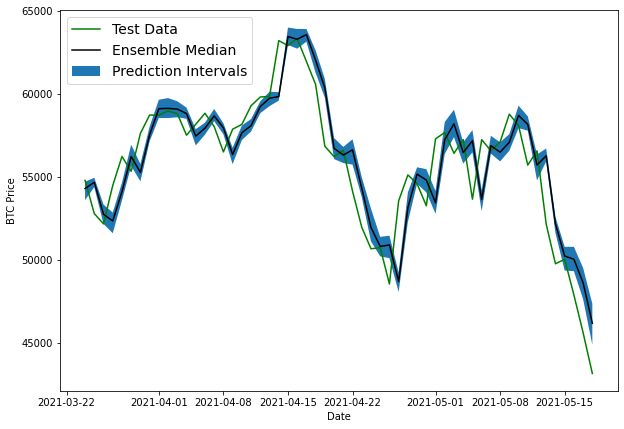

In [116]:
# Get the median values of our ensemble_preds

ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:],
                 (lower)[offset:],
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14)


### Model 9: Train a model on full historical data to make predictions into future

In [116]:
bitcoin_prices_windowed.head()

In [118]:
# Train model on entire data to make predictions for the next day

X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy()
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()

In [119]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features and labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [121]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_9.fit(dataset_all,
            epochs=100,
            verbose=0)